In [ ]:
from google.colab import files
files.upload()  # Select kaggle.json file when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ezzeldinaymansaraya","key":"0b86c8eaf0d4ca7b51b877c63f545d03"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Secure the file


In [ ]:
!kaggle datasets list


ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                         Car Price Dataset                                135KB  2025-01-26 19:53:28          21328        346  1.0              
abdulmalik1518/mobiles-dataset-2025                              Mobiles Dataset (2025)                            20KB  2025-02-18 06:50:24           4784         89  1.0              
mahmoudelhemaly/students-grading-dataset                         Student Performance & Behavior Dataset           508KB  2025-02-17 17:38:46           4036         78  1.0              
adilshamim8/workout-and-fitness-tracker-data                     Worko

In [ ]:
# Corrected download command
!kaggle datasets download -d ezzeldinaymansaraya/Dyslexia-Detection-Using-HandWritting

# Unzip with proper handling of spaces
!unzip '*.zip' -d "Dyslexia_Detection_Using_HandWritting/"


Streaming output truncated to the last 5000 lines.
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1266.4IOwg.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1267.sgNiH.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1268.okrK0.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1269.WGV1I.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1270.AAguI.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1271.acDMI.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1272.9422e.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-1273.9WXvR.png  
  inflating: Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train/Reversal/e-127

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models,transforms, datasets
from transformers import ViTImageProcessor, ViTForImageClassification, AutoTokenizer
import torch.optim as optim
import cv2
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

In [ ]:
import os

# ✅ Update the dataset path after unzipping
dataset_path = "/content/Dyslexia_Detection_Using_HandWritting"  # Adjust based on the actual extracted folder name

# ✅ Collect all image file paths
image_paths = []
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # ✅ Only image files
            image_paths.append(os.path.join(dirname, filename))

print(f"Total Images Found: {len(image_paths)}")


Total Images Found: 175300


In [ ]:
train_dir = "/content/Dyslexia_Detection_Using_HandWritting/Dataset Dyslexia_Hand/Train"

num_classes = 3
image_shape = (224, 224)

This **MakeDataset class** is a custom PyTorch Dataset designed to load images from a structured folder format. It extends torch.utils.data.Dataset, making it compatible with torch.utils.data.DataLoader for batch processing.

 * Extracts class names from subfolders.
 * Assigns labels to each class.
 * Scans all images and stores (image_path, label).
 * Handles missing/corrupt images with error handling.
 * Supports data transformations (resize, normalize, etc.).

In [ ]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=self.natural_key)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def natural_key(self, string_):
        try:
            return int(string_)
        except ValueError:
            return string_

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        try:
            image = Image.open(image_path).convert("RGB")
        except (OSError, IOError) as e:
            print(f"Skipping corrupted image: {image_path}, Error: {e}")
            # Return a zero tensor and a dummy label in case of error
            image = Image.new('RGB', (224, 224))  # Assuming the image size to be 224x224
            label = -1  # You might want to handle this label properly later

        if self.transform:
            image = self.transform(image)

        return image, label

Firstly the Transformation pipeline is used in PyTorch to preprocess images before passing them to neural network

     
1.  Resize the image (224,224) to make sure all images have the same dimensions before passing them to a neural network
2. Use **transforms.ToTensor()** to convert a PIL Image (Python Image Library) to Pytorch Tensor which means converts the image shape from (H,W,C) to (C,H,W)
    and scale the image pixels from [0,255] to [0,1] because Deep Learning Models perform better with normalized inputs , better precision .
3. Use **transforms.Normalize** Normalization of the pixel values to perform better in the pretrained models (improves training)
    

In [ ]:
transform = transforms.Compose([
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

The Dataset object created from the MakeDataSet Class Loads dataset from train_dir and applies transformations then return back the transformed training images

In [ ]:
dataset = MakeDataset(train_dir, transform=transform)

Split the dataset into training , validation , test using Pytorch function **random_split()**

In [ ]:
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = int(0.1 * len(dataset))    # 10% for validation
test_size = len(dataset) - train_size - val_size  # Remaining 10% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


The**DataLoader function** in PyTorch loads the dataset images in batches as defined with choosing either to shuffle in each epoch or no


**Shuffle** : to rearrange the data samples when training to make the model learn and memorize the features with different patterns


In [ ]:
batch_size=32 # DataLoader will load images in batches of 32 samples in one time

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Data Samples Visualizations** from the three DataLoaders using Numpy and matplotlib


Training Samples:


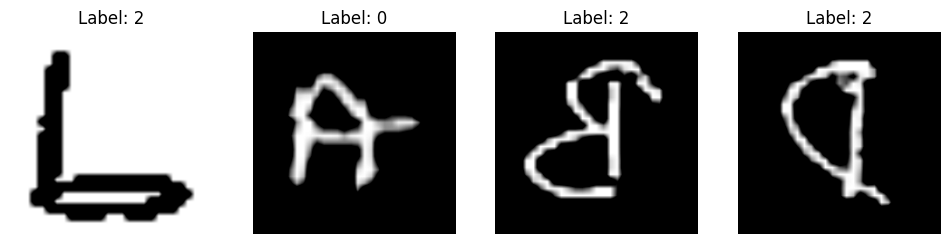

Validation Samples:


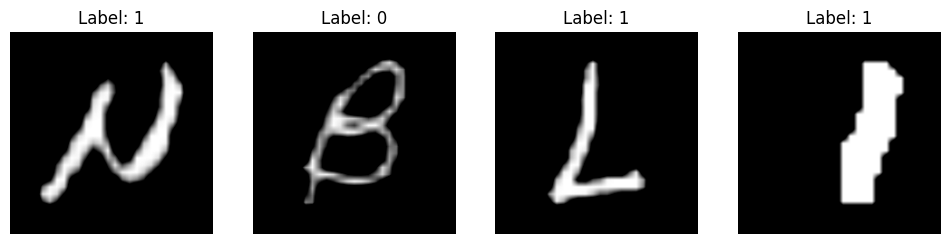

Testing Samples:


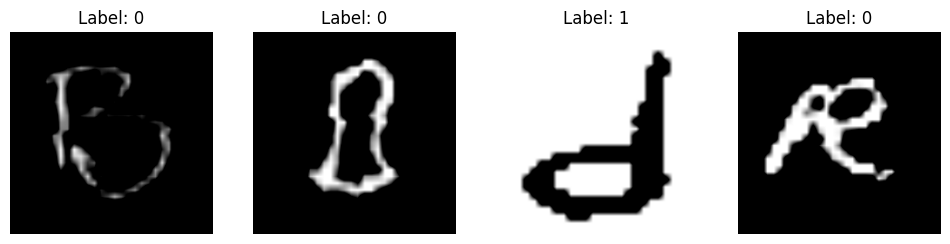

In [ ]:


# Define a function to visualize images from a DataLoader
def visualize(loader, num_samples=4):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(12, 5))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)

# Visualize samples from the validation loader
print("Validation Samples:")
visualize(val_loader)

print("Testing Samples:")
visualize(test_loader)

**MobileNet V3 Small**
  * Lightweight deep learning model
  * Lightweight CNN optimized for edge devices
  * balance speed and accuracy
  * Used for image classification (classifying an image into a category).
  * Size : 1.5MB
  * Speed Latency : 15ms

**MobileNet V3** is a pretrained model which was trained previously on a large dataset in this case (ImageNet)
Pretrained Model :
     * Saves time
     * Saves computational power
     * Can be Fine tuned
     
**What is Fine Tuning?**
        => Means modifying the pretrained model for a custom task
        * We modify the Fully connected layer (final classification layer) to match the number of classes in our custom task   
        Dataset
        
     

    
     

In [ ]:
model = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 163MB/s]


In [ ]:
in_features = model.classifier[0].in_features # extract input size of the last fc layer
out_features=3

# Modify the classifier layer to match the number of output classes
model.classifier = nn.Sequential(
    nn.Linear(in_features,  out_features), # replaces the original classifier to the one with the out classes

)

* What is loss function in classification? => measures how the predicted labels or the probabilities match the actual categories.
* We will use **CrossEntropy Loss**
* We can adjust the model's parameters through a process called Optimization => is an algorithm which updates the model weights during training to minimize the loss function.
* We will use **AdamW** =>  is a variant of the Adam optimizer that includes correct weight decay, making it better for regularization and preventing overfitting.


In [ ]:
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
 # the lr is the learning rate which determines how much the weights are updated during training
 # StepLR decreases the lr every stepsize epochs for better converge and improving
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
num_epochs = 5
desired_training_accuracy = 99.999  # Stop if training accuracy reaches this value
early_stopping_threshold = 3  # Stop if validation loss doesn't improve for 3 epochs
early_stopping_counter = 0  # Tracks epochs without improvement in validation loss
best_val_loss = float('inf')  # Stores the best (lowest) validation loss seen so far


In [ ]:
# Lists to store training and validation metrics for plotting curves
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
predictions = []
targets = []

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


In [ ]:
import time

start_time = time.time()

* **K-Fold Cross Validation** => splitting the dataset into folds(multiple subsets) and train the model multiple times
* Dataset splits into K folds (5 folds in this case) and the model is trained k times , each time using k-1 folds for training and 1 for validation
* **random_state=42** ensures the same shuffle for every run
* Why use?
    * ensure all data is used for training and validation
    * Reduces OverFitting


In [ ]:
from sklearn.model_selection import KFold

# Assume `dataset` is your PyTorch dataset
num_folds = 5
# Assuming train_dataset is your dataset
X = np.arange(len(train_dataset))  # Placeholder, you will index the dataset with this
y = np.array([label for _, label in train_dataset])  # Extract labels from the dataset
print(f"Dataset Size: {len(X)}, Labels Size: {len(y)}")
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-Fold Cross-Validation


Dataset Size: 121319, Labels Size: 121319


In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f'Fold {fold + 1}/{kf.n_splits}')

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

    best_acc = 0  # Reset the best accuracy for each fold

    fold_train_losses = []
    fold_train_accuracies = []
    fold_val_losses = []
    fold_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if -1 in labels:
                continue  # Skip the batch if it contains dummy labels

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch {epoch + 1}/{num_epochs}, Batch {i + 1}/{len(train_loader)}, '
                      f'Training Loss: {running_loss / 100:.4f}, Training Accuracy: {100 * correct_train / total_train:.2f}%')


        training_accuracy = correct_train / total_train
        fold_train_losses.append(running_loss / len(train_loader))
        fold_train_accuracies.append(training_accuracy)
        print(f'Training Accuracy after epoch {epoch + 1}/{num_epochs}: {100 * training_accuracy:.2f}%')


        model.eval()
        val_running_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                loss = criterion(val_outputs, val_labels)
                val_running_loss += loss.item()
                _, predicted_val = torch.max(val_outputs.data, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        validation_accuracy = correct_val / total_val
        validation_loss = val_running_loss / len(val_loader)
        fold_val_losses.append(validation_loss)
        fold_val_accuracies.append(validation_accuracy)


        if validation_accuracy > best_acc:
            best_acc = validation_accuracy
            torch.save(model.state_dict(), f'best_model_fold_{fold + 1}.pth')

        scheduler.step(validation_loss)


    avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
    print(f'Final Validation Accuracy for Fold {fold + 1}: {100 * avg_val_accuracy:.2f}%\n')

    # Store metrics for the entire fold
    train_losses.extend(fold_train_losses)
    train_accuracies.extend(fold_train_accuracies)
    val_losses.extend(fold_val_losses)
    val_accuracies.extend(fold_val_accuracies)


Fold 1/5
Epoch 1/5, Batch 100/3033, Training Loss: 0.5934, Training Accuracy: 76.19%
Epoch 1/5, Batch 200/3033, Training Loss: 0.8652, Training Accuracy: 82.80%
Epoch 1/5, Batch 300/3033, Training Loss: 1.1119, Training Accuracy: 85.26%
Epoch 1/5, Batch 400/3033, Training Loss: 1.2949, Training Accuracy: 87.30%
Epoch 1/5, Batch 500/3033, Training Loss: 1.4642, Training Accuracy: 88.67%
Epoch 1/5, Batch 600/3033, Training Loss: 1.6009, Training Accuracy: 89.72%
Epoch 1/5, Batch 700/3033, Training Loss: 1.7168, Training Accuracy: 90.60%
Epoch 1/5, Batch 800/3033, Training Loss: 1.8268, Training Accuracy: 91.29%
Epoch 1/5, Batch 900/3033, Training Loss: 1.9334, Training Accuracy: 91.83%
Epoch 1/5, Batch 1000/3033, Training Loss: 2.0192, Training Accuracy: 92.32%
Epoch 1/5, Batch 1100/3033, Training Loss: 2.1161, Training Accuracy: 92.69%
Epoch 1/5, Batch 1200/3033, Training Loss: 2.2151, Training Accuracy: 93.02%
Epoch 1/5, Batch 1300/3033, Training Loss: 2.3013, Training Accuracy: 93.36%

In [ ]:
end_time = time.time()

duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60

print("Training duration: {:.2f} minutes".format(duration_minutes))

Training duration: 129.80 minutes


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the paths for each fold



model_paths = [
    '/content/best_model_fold_1.pth',
    '/content/best_model_fold_2.pth',
    '/content/best_model_fold_3.pth',
    '/content/best_model_fold_4.pth',
    '/content/best_model_fold_5.pth'
]

# Placeholder for the best model and best performance
best_model = None
best_f1_score = float('-inf')  # If maximizing F1-score. Change to float('inf') if minimizing.

# Function to evaluate the model and calculate metrics on a given dataset (validation or test)
def evaluate_model(model, loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for inputs, labels in loader:  # Loop through the DataLoader (val_loader or test_loader)
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get the predicted class
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate accuracy
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = correct / total  # Accuracy = correct predictions / total predictions

    return precision, recall, f1, accuracy

# Iterate over each model, load it, and evaluate it on both validation and test sets
for path in model_paths:
    model.load_state_dict(torch.load(path))  # Load model weights
    model.to(device)  # Move model to the selected device (CPU or GPU)

    # Evaluate on validation set
    val_precision, val_recall, val_f1, val_accuracy = evaluate_model(model, val_loader)
    print(f'Model {path} - Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation F1-Score: {val_f1}, Validation Accuracy: {val_accuracy}')

    # Evaluate on test set
    test_precision, test_recall, test_f1, test_accuracy = evaluate_model(model, test_loader)
    print(f'Model {path} - Test Precision: {test_precision}, Test Recall: {test_recall}, Test F1-Score: {test_f1}, Test Accuracy: {test_accuracy}')

    # Update the best model if F1-Score on validation is better
    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        best_model = model

print(f'The best model is from: {model_paths[model_paths.index(path)]} with Validation F1-Score: {best_f1_score}')


<ipython-input-65-7eb631d1e05c>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /content/best_model_fold_1.pth - Validation Precision: 0.9965648530845068, Validation Recall: 0.9965261014770995, Validation F1-Score: 0.9965453018110394, Validation Accuracy: 0.9966615834810205
Model /content/best_model_fold_1.pth - Test Precision: 0.9931323716573676, Test Recall: 0.9922374415470786, Test F1-Score: 0.9926785928244953, Test Accuracy: 0.992812870895424


<ipython-input-65-7eb631d1e05c>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /content/best_model_fold_2.pth - Validation Precision: 0.9965526300582489, Validation Recall: 0.9971653263517063, Validation F1-Score: 0.9968556964092118, Validation Accuracy: 0.9968264435560318
Model /content/best_model_fold_2.pth - Test Precision: 0.9930704877343199, Test Recall: 0.993779352177993, Test F1-Score: 0.9934202748259736, Test Accuracy: 0.9934722405380456


<ipython-input-65-7eb631d1e05c>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /content/best_model_fold_3.pth - Validation Precision: 0.9994811080163689, Validation Recall: 0.9993290164426784, Validation F1-Score: 0.9994049301679766, Validation Accuracy: 0.9994229897374604
Model /content/best_model_fold_3.pth - Test Precision: 0.9955945014291337, Test Recall: 0.99561589862219, Test F1-Score: 0.9956034776684497, Test Accuracy: 0.9957800342872214


<ipython-input-65-7eb631d1e05c>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /content/best_model_fold_4.pth - Validation Precision: 0.9998706060801178, Validation Recall: 0.9998631493495269, Validation F1-Score: 0.9998668741081209, Validation Accuracy: 0.9998763549437415
Model /content/best_model_fold_4.pth - Test Precision: 0.9955508289643253, Test Recall: 0.9958004333225291, Test F1-Score: 0.9956745110452915, Test Accuracy: 0.9958459712514836


<ipython-input-65-7eb631d1e05c>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))  # Load model weights


Model /content/best_model_fold_5.pth - Validation Precision: 0.9992011994478988, Validation Recall: 0.9991258564656178, Validation F1-Score: 0.999163482706574, Validation Accuracy: 0.9991756996249433
Model /content/best_model_fold_5.pth - Test Precision: 0.9954559051630559, Test Recall: 0.9952482393571924, Test F1-Score: 0.9953507502955649, Test Accuracy: 0.9955822233944349
The best model is from: /content/best_model_fold_5.pth with Validation F1-Score: 0.9998668741081209


In [ ]:
# Set the model to evaluation mode
best_model.eval()
correct = 0
total = 0

In [ ]:
# Initialize lists to store predictions and true labels
all_labels = []
all_predictions = []

In [ ]:
# Disable gradient computation for testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and true labels for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

In [ ]:
# Calculate and print the test accuracy
test_accuracy = correct / total
print(f'Test Accuracy: {100 * test_accuracy}%')

# Compute precision, recall, f1-score and confusion matrix
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

Test Accuracy: 99.55822233944349%


In [ ]:
# Print the metrics
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

Precision: 99.56%
Recall: 99.56%
F1 Score: 99.56%


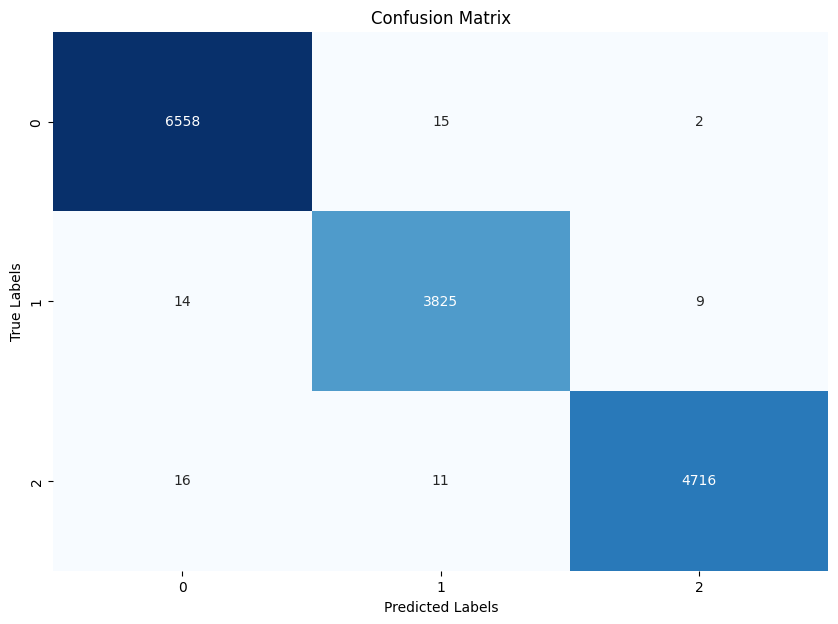

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM
from torchvision import models
import numpy as np

In [ ]:
# Define the Grad-CAM extractor
# Get the name of the desired layer (e.g., the last convolutional layer)
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        last_conv_layer_name = name  # Store the name of the last Conv2d layer

# Now, use this layer name in GradCAM
cam_extractor = GradCAM(model, target_layer=last_conv_layer_name)

In [ ]:
# Function to denormalize the image for plotting
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    img = img * std + mean
    return img.clamp(0, 1)

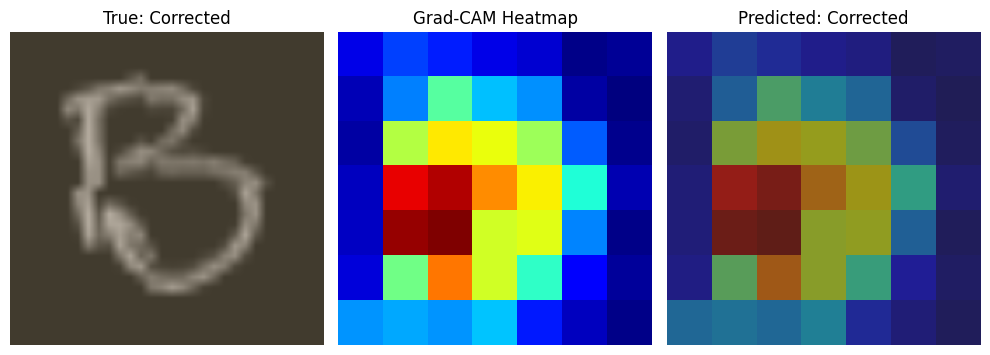

In [ ]:
# Iterate over the test set
for i, (inputs, labels) in enumerate(test_loader):
    # Move the inputs and labels to the same device as the model
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass (do not use torch.no_grad() here, since Grad-CAM needs gradients)
    outputs = best_model(inputs)

    # Get the predicted class (index [0] extracts the value from the tensor)
    predicted = outputs.argmax(dim=1)[0].item()

    # Extract the CAM for the predicted class
    activation_map = cam_extractor(predicted, outputs)

    # Average the activation map across the channel dimension to get a 2D heatmap
    heatmap = activation_map[0].mean(dim=0).cpu().numpy()

    # Plotting
    plt.figure(figsize=(10, 5))

    # Original image
    ax1 = plt.subplot(1, 3, 1)
    img = denormalize(inputs[0], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    img = img.permute(1, 2, 0).cpu().numpy()  # Move the tensor back to CPU for plotting
    ax1.imshow(img)
    ax1.set_title(f'True: {dataset.classes[labels[0].item()]}')  # Extract the scalar value from labels
    ax1.axis('off')

    # Heatmap
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(heatmap, cmap='jet')  # Display the 2D heatmap
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')

    # Overlay the heatmap on the image
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(img)
    ax3.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay with transparency
    ax3.set_title(f'Predicted: {dataset.classes[predicted]}')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

    # Stop after the first example for demonstration; remove this line to iterate over all
    if i == 0:
        break